<a href="https://colab.research.google.com/github/djliden/deep_learning_practice/blob/main/ch6_other_computer_vision_problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This chapter covers multi-label classification and regression. The former is for when there are multiple labels per image; the latter for when the labels are numbers.

## Multi-label classification
Using the PASCAL dataset, which can have more than one kind of classified object per image.

In [1]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

The labels in this dataset are contained in a CSV file. Each filename is associated with a space-delimited list of labels.

In [2]:
import pandas as pd
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


We can use the `DataBlock` API to get from the pandas dataframe to a `DataLoaders` object. JH suggests starting by putting together a `Dataset` for simplicity as the `DataLoaders` extends on the functionality of the `Datasets`.

In [3]:
dblock = DataBlock() # init empty
dsets = dblock.datasets(df)
dsets.train[0]

(fname       003792.jpg
 labels             dog
 is_valid         False
 Name: 1911, dtype: object,
 fname       003792.jpg
 labels             dog
 is_valid         False
 Name: 1911, dtype: object)

This just returns a row of the pandas dataframe, twice because it assumes input and target but we didn't tell it how to find either specifically.

In [5]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('000177.jpg', 'diningtable person')

The book notes that `lambda` functions are useful for experimenting but that we should use the more verbose approch for production as `lambda`s don't work for serialization (?).

It looks like the functions takes the whole pandas dataframe as an argument and returns the correct columns.

Next we need to convert the independent variable to a complete path so we can open it as an image. We also need to convert the dependent variable to a list as there are multiple categories.

In [6]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/home/djliden91/.fastai/data/pascal_2007/train/002015.jpg'),
 ['pottedplant'])

Specifying the block types will suffice to conduct the necessary transformation of e.g. images to tensors.

In [7]:
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                   get_x = get_x,
                   get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0.]))

In [26]:
dsets.vocab[0:10],dsets.vocab[10:] # HOW DO I PRINT ALL?

((#10) ['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow'],
 (#10) ['diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor'])

In [27]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['train']

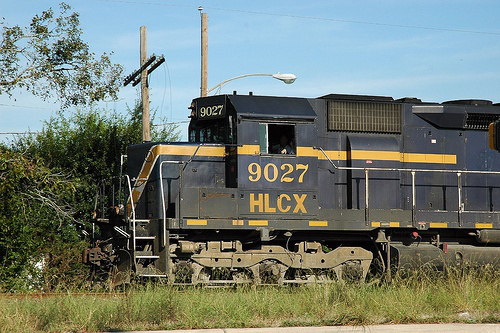

In [40]:
dsets.train[0][0]

So just calling the index directly displays the image. Interesting. Is that a notebook thing or will it work from other interpreter? I'll have to check.

In [44]:
idxs, torch.where(dsets.train[0][1]==1.), dsets.train[0][1]

(tensor([18]),
 (tensor([18]),),
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0.]))

So `torch.where` returns the index of what matches the condition within. What if we invert?

In [51]:
torch.where(dsets.train[0][1]!=1.)

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         19]),)

By default a tuple is returned. By taking the 0 index, we get the tensor within. Why is that? Another way:

In [57]:
torch.nonzero(dsets.train[0][1], as_tuple=False)

tensor([[18]])

In [58]:
dsets.train.vocab[torch.nonzero(dsets.train[0][1], as_tuple=False)]

(#1) ['train']

Anyway, lots of ways to get at the same thing. Time to move on. The last thing we need to do is tell the `DataBlock` how to split the data. In this case, there is a column in the dataframe, `is_valid`, telling us whether we're dealing with the training or validation sets.

In [60]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x = get_x,
                   get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

The `~` operator in python is for negation! I did not know this.